#### Modules and definitions

In [111]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Machine learning modules
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, LeaveOneGroupOut, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier

# Function to load and preprocess images
def load_image(image_path, resize_shape=None):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 00 image in grayscale
    if resize_shape is not None:
        image = cv2.resize(image, resize_shape)  # Resize image to a fixed size
    return image.flatten()  # Flatten image to a 1D array

# General random_state for reproducibility
random_state = 0

#### Load dataset of image labels

In [112]:
# Step 1: Load your dataset using pandas
# Assuming your dataset is in CSV format

dataset_path = "data/splits/sgkf-6-2-2-size-2024-rs-3/images.csv"
# dataset_path = "data/splits/sgkf-50-25-25-size-2000/images.csv"
df = pd.read_csv(dataset_path, index_col=0)

print('Nº of images per camera:')
df['code'].value_counts().to_frame('images').T

Nº of images per camera:


code,235.0,326.0,339.0,92.0,1393.0,1538.0,298.0,1119.0,384.0,38.0,...,1147.0,442.0,94.0,267.0,1881.0,430.0,1431.0,268.0,313.0,1475.0
images,72,72,72,72,72,72,72,72,72,72,...,72,72,72,72,72,72,56,38,30,28


#### Sample the dataset per camera

In [113]:
n_camera_samples = 72

# Regular sample
# n_cameras = len(df['code'].unique())
# n_samples = n_cameras * n_camera_samples
# df_sample = df.sample(, replace=False, random_state=random_state)

# Sample per camera
code_cnt = df['code'].value_counts()
code_samples = [
    df[df['code'] == code].sample(min(n_camera_samples, code_cnt[code]), replace=False, random_state=random_state)
    for code in df['code'].unique()
]
df_sample = pd.concat(code_samples)

print('Max. Samples per Camera:', n_camera_samples)
print('Nº of Cameras:', len(df_sample['code'].unique()))
print('Nº of Samples:', len(df_sample))
pd.concat([df_sample['code'].value_counts().rename('Sample'), df['code'].value_counts().rename('Total')], axis=1).T

Max. Samples per Camera: 72
Nº of Cameras: 30
Nº of Samples: 2024


code,235.0,326.0,339.0,92.0,1393.0,1538.0,298.0,1119.0,384.0,38.0,...,1147.0,442.0,94.0,267.0,1881.0,430.0,1431.0,268.0,313.0,1475.0
Sample,72,72,72,72,72,72,72,72,72,72,...,72,72,72,72,72,72,56,38,30,28
Total,72,72,72,72,72,72,72,72,72,72,...,72,72,72,72,72,72,56,38,30,28


#### Load and convert images to flat numpy arrays

In [114]:
# ---
# Parameters
base_dir = 'data/images'
# resize_shape = None
resize_shape = (256, 256)
image_paths = df_sample['file_path'].map(lambda path: f'{base_dir}/{path}') # paths to images
labels = df_sample['flood'] # image labels

# List to store image data and file paths
images = []

# Loop through each image path
for path in image_paths:
    try:
        image = load_image(path, resize_shape)  # Load and preprocess image
        images.append(image)  # Append flattened image to list
        # labels.append(label)  # Append label to list
        print(f'Images Loaded: {len(images)}/{len(image_paths)}', end='\r')
    except Exception as e:
        print(f"Error loading image: '{path}': {e}")
print('\nFinished!')

# Convert lists to numpy arrays
images = np.array(images)

Images Loaded: 2024/2024
Finished!


#### Convert array of flat images to pandas dataframe

In [115]:
# Create DataFrame
data = pd.DataFrame(images)
data['label'] = labels.values

# Display DataFrame
display(data.head())
print(data.shape)


,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,3,10,5,77,78,75,73,77,80,83,...,69,68,65,65,63,58,56,54,51,0
1,5,8,4,26,29,35,33,30,34,38,...,50,50,50,48,48,48,48,48,48,0
2,3,6,5,43,42,45,55,50,52,62,...,17,19,23,23,23,15,15,54,108,1
3,7,6,13,121,109,119,127,129,124,130,...,48,48,49,44,43,44,44,43,43,0
4,6,10,3,41,39,42,52,47,52,46,...,49,43,40,44,49,53,58,57,53,0


(2024, 65537)


#### Get X and y

In [116]:
# Preprocess your data and split it into features and target variable
# Assuming the last column is the target variable and rest are features
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Target variable

#### Set split strategy

In [117]:
test_prct = 0.2
n_splits_test = int(1.0 / test_prct)

gkf = GroupKFold(n_splits=n_splits_test)
sgkf = StratifiedGroupKFold(n_splits=n_splits_test, shuffle=True, random_state=random_state)
logo = LeaveOneGroupOut()

# Choose data split algorithm
splitter = sgkf

print('\nSplit Strategy:', splitter, '\n')


Split Strategy: StratifiedGroupKFold(n_splits=5, random_state=0, shuffle=True) 



#### Define evaluation metrics

In [118]:
from sklearn.metrics import classification_report as cr

def CR(estimator, X, y):
    y_pred = estimator.predict(X)
    scores = cr(y, y_pred, output_dict=True)
    return scores

def recall_1(estimator, X, y):
    scores = CR(estimator, X, y)
    return scores['1']['recall']

def accuracy(estimator, X, y):
    scores = CR(estimator, X, y)
    return scores['accuracy']

#### Define model

In [119]:
# Step 3: Define machine learning model
# model = LogisticRegression(penalty='l2', verbose=1, random_state=random_state)
model = SGDClassifier(loss='hinge', penalty='l2', random_state=random_state, verbose=1) # 
# model = LinearSVC(random_state=random_state)
# model = SVC(kernel='rbf', gamma='auto', verbose=1, random_state=random_state, probability=True)
# model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, early_stopping=True, random_state=random_state, verbose=1)

# Step 4: Define model pipeline
pipe = make_pipeline(StandardScaler(), model)
print(f'\nModel Hyperparameters:\n')
display(model.get_params()); print()


Model Hyperparameters:



{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 1,
 'warm_start': False}

#### Evaluate on single split folder

In [120]:
scorer = CR

train_msk = (df_sample['set'] == 'train').values
test_msk = (df_sample['set'] == 'test').values
val_msk = (df_sample['set'] == 'val').values

X_train, Y_train = X[train_msk], y[train_msk]
X_test, Y_test = X[test_msk], y[test_msk]
X_val, Y_val = X[val_msk], y[val_msk]

model_fit = pipe.fit(X_train, Y_train)

print()
display(scorer(model_fit, X_test, Y_test))
print()
display(scorer(model_fit, X_val, Y_val))

-- Epoch 1
Norm: 13474.74, NNZs: 65536, Bias: -36.854253, T: 1160, Avg. loss: 25970.833408
Total training time: 0.27 seconds.
-- Epoch 2
Norm: 10264.40, NNZs: 65536, Bias: -85.114154, T: 2320, Avg. loss: 3921.536108
Total training time: 0.53 seconds.
-- Epoch 3
Norm: 8461.68, NNZs: 65536, Bias: -114.875673, T: 3480, Avg. loss: 1864.370096
Total training time: 0.76 seconds.
-- Epoch 4
Norm: 7315.67, NNZs: 65536, Bias: -117.849207, T: 4640, Avg. loss: 1082.719597
Total training time: 1.00 seconds.
-- Epoch 5
Norm: 6260.49, NNZs: 65536, Bias: -122.623275, T: 5800, Avg. loss: 248.585714
Total training time: 1.24 seconds.
-- Epoch 6
Norm: 5567.76, NNZs: 65536, Bias: -123.015268, T: 6960, Avg. loss: 258.494231
Total training time: 1.48 seconds.
-- Epoch 7
Norm: 4973.73, NNZs: 65536, Bias: -128.625457, T: 8120, Avg. loss: 143.969460
Total training time: 1.74 seconds.
-- Epoch 8
Norm: 4487.87, NNZs: 65536, Bias: -124.356590, T: 9280, Avg. loss: 85.199682
Total training time: 2.00 seconds.
-- E

{'0': {'precision': 0.5765124555160143,
  'recall': 0.75,
  'f1-score': 0.6519114688128772,
  'support': 216},
 '1': {'precision': 0.6423841059602649,
  'recall': 0.44907407407407407,
  'f1-score': 0.5286103542234333,
  'support': 216},
 'accuracy': 0.5995370370370371,
 'macro avg': {'precision': 0.6094482807381396,
  'recall': 0.599537037037037,
  'f1-score': 0.5902609115181552,
  'support': 432},
 'weighted avg': {'precision': 0.6094482807381396,
  'recall': 0.5995370370370371,
  'f1-score': 0.5902609115181553,
  'support': 432}}

{'0': {'precision': 0.5481927710843374,
  'recall': 0.4212962962962963,
  'f1-score': 0.47643979057591623,
  'support': 216},
 '1': {'precision': 0.5300751879699248,
  'recall': 0.6527777777777778,
  'f1-score': 0.5850622406639004,
  'support': 216},
 'accuracy': 0.5370370370370371,
 'macro avg': {'precision': 0.539133979527131,
  'recall': 0.537037037037037,
  'f1-score': 0.5307510156199083,
  'support': 432},
 'weighted avg': {'precision': 0.5391339795271312,
  'recall': 0.5370370370370371,
  'f1-score': 0.5307510156199083,
  'support': 432}}

#### Evaluate on all split folders

In [ ]:
from sklearn.model_selection import cross_validate

result = cross_validate(
    pipe,
    X,
    y,
    cv=splitter,  # Number of cross-validation folds
    scoring={'accuracy': accuracy, 'recall_1': recall_1},  # Scoring metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,
    groups=df_sample['code'].values,
    error_score='raise',
    pre_dispatch='all',
    return_train_score=True,
    return_estimator=True,
)

display(pd.DataFrame(result))

#### Fit and evaluate model for each split for increasing train size

In [127]:
min_images_per_camera = 5
max_images_per_camera = 65
n_sizes = 5

xmin = min_images_per_camera / n_camera_samples
xmax = max_images_per_camera / n_camera_samples

# Step 5: Use the learning_curve function to generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe,
    X=X,
    y=y,
    train_sizes=np.linspace(xmin, xmax, n_sizes),  # Varying training set sizes
    cv=splitter,  # Number of cross-validation folds
    scoring=accuracy,  # Scoring metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,
    shuffle=True,
    groups=df_sample['code'].values,
    random_state=random_state,
    error_score='raise',
)

[learning_curve] Training set sizes: [ 114  456  798 1140 1482]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.2min finished


---
## Visualize results

#### Display learning curves

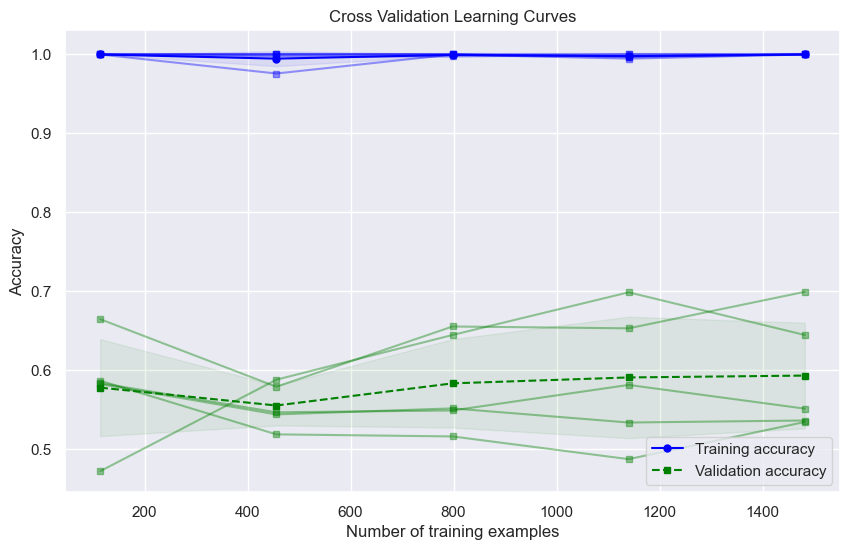

C:\Users\luisr\anaconda3\Lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\luisr\AppData\Local\Temp\joblib_memmapping_folder_20336_2e657212aa6b4799887519c9c7426961_a95ce86ba7e444c29e3b7610e65c8ac9
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\luisr\anaconda3\Lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\luisr\AppData\Local\Temp\joblib_memmapping_folder_20336_2186dec32cef45df84665e385d1951ff_f3fcc0ca2e214591b3e3f67a8f3de022
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\luisr\anaconda3\Lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\luisr\AppData\Local\Temp\joblib_memmapping_folder_20336_2e550ecb9fb142508a4abbfe506f6c6c_d8e045d5a59a4a98b3deeb194de4bb84
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\luisr\anaconda3\Lib\site-packages\joblib\_memmapping

In [128]:
# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.07, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.07, color='green')

for i in range(len(train_scores[0])):
    plt.plot(train_sizes, train_scores[:, i], marker='s', markersize=5, alpha=0.40, color='blue')
    plt.plot(train_sizes, test_scores[:, i], marker='s', markersize=5, alpha=0.40, color='green')

plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.title('Cross Validation Learning Curves')
plt.legend(loc='lower right')
# plt.grid()
plt.show()

#### Display evaluation metrics

In [21]:
print('\nTrain Scores:')
display(pd.DataFrame(train_scores, index=pd.Series(train_sizes, name='Train Size')))
print('\nTest Scores:')
display(pd.DataFrame(test_scores, index=pd.Series(train_sizes, name='Train Size')))



Train Scores:


,0,1,2,3,4
Train Size,,,,,
22,0.863636,1.000000,1.000000,0.954545,0.954545
74,0.959459,0.986486,0.932432,0.932432,0.945946
125,0.976000,0.976000,0.936000,0.928000,0.936000
176,0.977273,0.965909,0.931818,0.931818,0.965909
228,0.964912,0.964912,0.947368,0.929825,0.960526



Test Scores:


,0,1,2,3,4
Train Size,,,,,
22,0.500000,0.500000,0.500000,0.650463,0.497436
74,0.534031,0.603093,0.553241,0.490741,0.517949
125,0.554974,0.603093,0.631944,0.696759,0.530769
176,0.505236,0.564433,0.576389,0.692130,0.564103
228,0.520942,0.569588,0.469907,0.708333,0.546154
